In [ ]:
# install requred packages, uncomment below line and run , it will install all the required packages.
# !pip install Flask==2.2.3
# !pip install torch
# !pip install torchvision
# !pip install Pillow==9.5.0
# !pip install kagglehub==0.1.1
# !pip install seaborn==0.12.2
# !pip install matplotlib==3.7.1
# !pip install scikit-learn==1.3.0
# !pip install numpy
# !pip install pandas

In [1]:
# Download dataset from kaggle.
import kagglehub
# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepfake-and-real-images


In [2]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
import torch
from torch import nn, optim
# import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


Here, we're setting the device to either GPU or CPU, depending on availability. We also import essential libraries like torch, torchvision, and matplotlib.

In [3]:
train_path = os.path.join(path, "Dataset/Train")
val_path = os.path.join(path, "Dataset/Validation")
test_path = os.path.join(path, "Dataset/Test")
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

The paths for training, validation, and test data are set. The transformations include resizing images, applying random horizontal flips for augmentation, and normalizing using ImageNet pre-trained values.

In [4]:
# Data Loading
train_data = datasets.ImageFolder(path+"/Dataset/Train", transform=train_transform)
val_data = datasets.ImageFolder(path+"/Dataset/Validation", transform=val_test_transform)
test_data = datasets.ImageFolder(path+"/Dataset/Test", transform=val_test_transform)

The data is loaded from the directories into train_data, val_data, and test_data using ImageFolder. These datasets are preprocessed with the transformations defined in the previous cell.

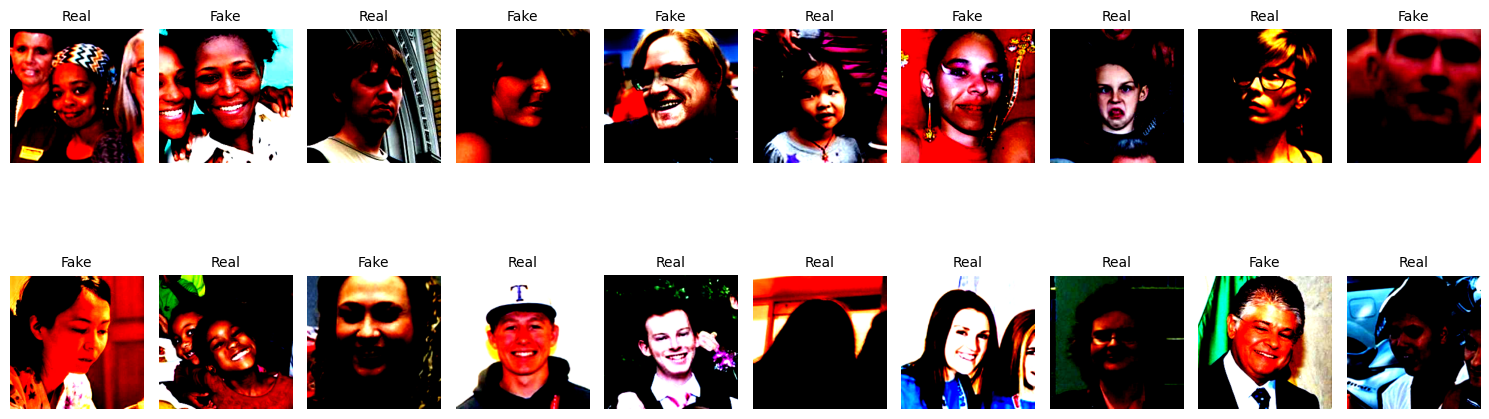

In [5]:
def plot_samples(dataset, n=20, cols=10):
    rows = (n + cols - 1) // cols  # calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()
    for i in range(n):
        img, label = random.choice(dataset)
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(dataset.classes[label], fontsize=10)
        axes[i].axis("off")
    # turn off remaining axes if n is not a multiple of cols
    for i in range(n, len(axes)):
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


plot_samples(train_data, n=20)

This function displays n random images from the dataset along with their labels, giving you a quick overview of the dataset.

In [6]:
# Use 20% of training data

subset_size = int(0.2 * len(train_data))
train_subset = Subset(train_data, random.sample(range(len(train_data)), subset_size))


# Use 20% of test data

subset_size = int(0.2 * len(test_data))
test_subset = Subset(test_data, random.sample(range(len(test_data)), subset_size))


# Use 20% of validation data

subset_size = int(0.2 * len(val_data))
val_subset = Subset(val_data, random.sample(range(len(val_data)), subset_size))
train_loader = DataLoader(train_subset, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, num_workers=4)
test_loader = DataLoader(test_subset, batch_size=32, num_workers=4)

A random subset of 20% of the training, validation, and test data is used to make initial experimentation faster. DataLoader objects are created for each subset.

## Creating custom model and Training

In [7]:
# creating custom model architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # Output: 2 classes (Fake, Real)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


custom_model = CustomCNN().to(device)
print(custom_model)

CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
# Training custom model
def train_custom_model(model, criterion, optimizer, scheduler, num_epochs=15):
    train_loss, val_loss = [], []
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss, correct = 0.0, 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = correct.double() / len(loader.dataset)

            if phase == "train":
                train_loss.append(epoch_loss)
                scheduler.step()
            else:
                val_loss.append(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss


custom_model, train_loss, val_loss = train_custom_model(
    custom_model, criterion, optimizer, scheduler, num_epochs=15
)

Epoch 1/15
------------------------------
train Loss: 0.7569 Acc: 0.5651
val Loss: 0.5802 Acc: 0.6845
Epoch 2/15
------------------------------
train Loss: 0.4986 Acc: 0.7505
val Loss: 0.5233 Acc: 0.7342
Epoch 3/15
------------------------------
train Loss: 0.4437 Acc: 0.7875
val Loss: 0.4972 Acc: 0.7542
Epoch 4/15
------------------------------
train Loss: 0.4024 Acc: 0.8126
val Loss: 0.4751 Acc: 0.7803
Epoch 5/15
------------------------------
train Loss: 0.3563 Acc: 0.8391
val Loss: 0.4498 Acc: 0.7930
Epoch 6/15
------------------------------
train Loss: 0.3198 Acc: 0.8611
val Loss: 0.4235 Acc: 0.7953
Epoch 7/15
------------------------------
train Loss: 0.2798 Acc: 0.8799
val Loss: 0.4181 Acc: 0.8082
Epoch 8/15
------------------------------
train Loss: 0.2175 Acc: 0.9096
val Loss: 0.4365 Acc: 0.8192
Epoch 9/15
------------------------------
train Loss: 0.1994 Acc: 0.9169
val Loss: 0.4569 Acc: 0.8209
Epoch 10/15
------------------------------
train Loss: 0.1862 Acc: 0.9233
val Loss

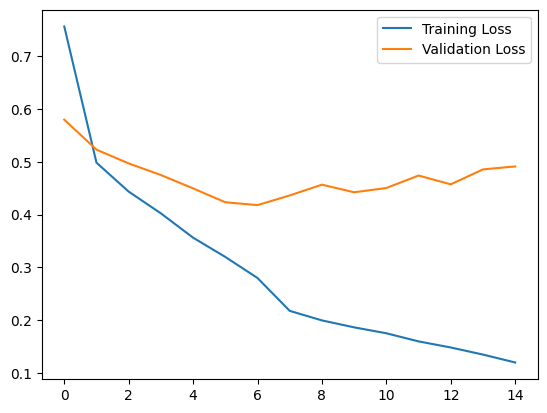

In [10]:
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

- Above figure is showing Training loss vs validation loss for custom model

In [11]:
custom_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = custom_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

print(f"Test Accuracy: {correct.double() / total:.4f}")

Test Accuracy: 0.7868


- For custom model , got `78%` of testing accuracy

In [12]:
# Save the trained custom model
torch.save(custom_model.state_dict(), "custom_model.pth")
print("Custom model saved as custom_model.pth")

# Load the saved model
custom_model.load_state_dict(torch.load("/content/model.pth"))
custom_model.eval()
print("Custom model loaded successfully")

Custom model saved as custom_model.pth
Custom model loaded successfully


- After custom model training save model for future use

              precision    recall  f1-score   support

        Fake       0.77      0.80      0.79      1080
        Real       0.80      0.77      0.78      1101

    accuracy                           0.79      2181
   macro avg       0.79      0.79      0.79      2181
weighted avg       0.79      0.79      0.79      2181



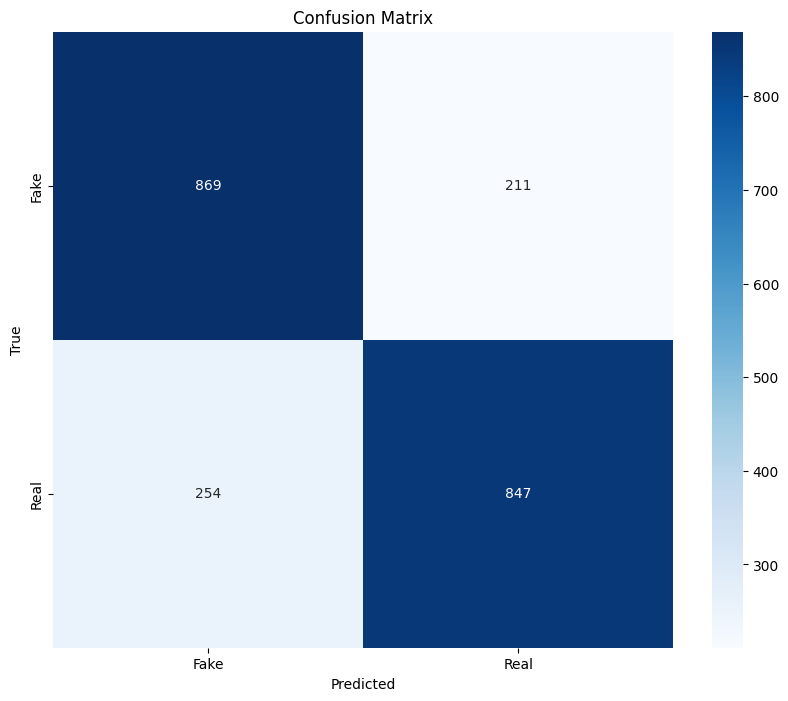

In [13]:
def evaluate_model(model, test_loader, classes, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # classification Report
    print(classification_report(all_labels, all_preds, target_names=classes))

    # confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate custom model
evaluate_model(custom_model, test_loader, test_data.classes, device)

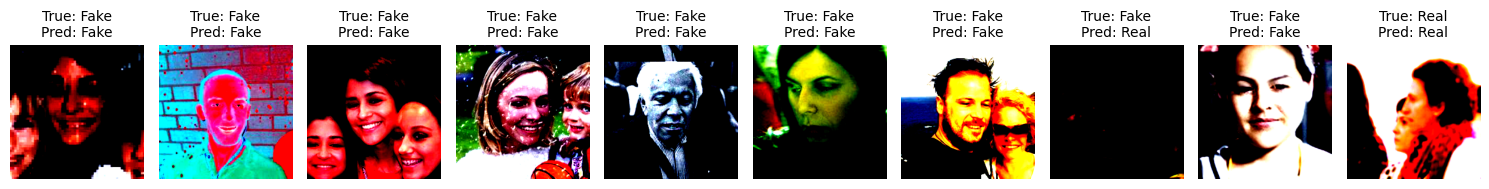

In [14]:
def plot_predictions(model, dataset, classes, device, n=10):
    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    axes = axes.flatten()
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.to(device).unsqueeze(0)  # add batch dimension
        with torch.no_grad():
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
        # plot the image
        img = img.squeeze().cpu().permute(1, 2, 0)  # convert to HWC format
        axes[i].imshow(img)
        axes[i].set_title(f"True: {classes[label]}\nPred: {classes[pred]}", fontsize=10)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


# plot predictions
plot_predictions(custom_model, test_data, test_data.classes, device, n=10)

## Using pre-trained model `Resnet`

In [16]:
# Load pre-trained ResNet18

model = models.resnet18(pretrained=True)
# freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
# modify the final layer to match the number of classes in our dataset (2: Fake and Real)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s] 


then employed ResNet-18, a convolutional neural network pre-trained on ImageNet, as the base model. Since the number of classes in the dataset is 2 (Fake and Real), I modified the final fully connected layer of ResNet-18 to output 2 units, corresponding to the two classes. The model’s parameters are frozen during the initial training phase to prevent large-scale changes to the pre-trained weights. Only the final layer's weights are updated during training.

In [17]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
# training Loop
# training Restnet mode on our dataset
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    train_loss, val_loss = [], []
    best_model_wts = model.state_dict()
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            running_loss, correct = 0.0, 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = correct.double() / len(loader.dataset)
            if phase == "train":
                train_loss.append(epoch_loss)
                scheduler.step()
            else:
                val_loss.append(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss


model, train_loss, val_loss = train_model(
    model, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
------------------------------
train Loss: 0.4612 Acc: 0.7774
val Loss: 0.4569 Acc: 0.7795
Epoch 2/15
------------------------------
train Loss: 0.4106 Acc: 0.8089
val Loss: 0.4353 Acc: 0.7964
Epoch 3/15
------------------------------
train Loss: 0.3984 Acc: 0.8185
val Loss: 0.4335 Acc: 0.8015
Epoch 4/15
------------------------------
train Loss: 0.3981 Acc: 0.8160
val Loss: 0.4412 Acc: 0.8008
Epoch 5/15
------------------------------
train Loss: 0.3909 Acc: 0.8218
val Loss: 0.4264 Acc: 0.8006
Epoch 6/15
------------------------------
train Loss: 0.4046 Acc: 0.8172
val Loss: 0.4298 Acc: 0.8014
Epoch 7/15
------------------------------
train Loss: 0.3915 Acc: 0.8227
val Loss: 0.4440 Acc: 0.7945
Epoch 8/15
------------------------------
train Loss: 0.3743 Acc: 0.8320
val Loss: 0.4382 Acc: 0.7973
Epoch 9/15
------------------------------
train Loss: 0.3761 Acc: 0.8274
val Loss: 0.4336 Acc: 0.7989
Epoch 10/15
------------------------------
train Loss: 0.3753 Acc: 0.8280
val Loss

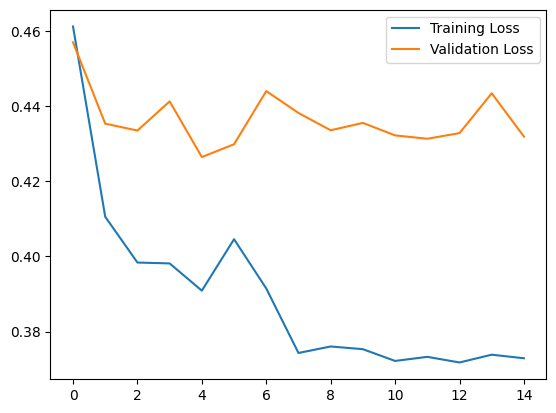

In [19]:
# Plot training/validation loss

plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

- Above figure is shows training loss vs validation loss of resnet model on our dataset

In [20]:
# Test the model

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)


print(f"Test Accuracy: {correct.double() / total:.4f}")

Test Accuracy: 0.7043


- Test accuracy of resnet model on our random data is `70%`

In [ ]:
# save the trained model
torch.save(model.state_dict(), "resnet_model.pth")
print("Model saved as resnet_model.pth")

- save resnet model for future use

In [23]:
# load the model

# model.load_state_dict(torch.load("/content/model.pth"))
model.load_state_dict(torch.load("/content/resnet_model.pth"))
model.eval()

print("Model loaded successfully")

Model loaded successfully


              precision    recall  f1-score   support

        Fake       0.68      0.75      0.72      1080
        Real       0.73      0.65      0.69      1101

    accuracy                           0.70      2181
   macro avg       0.71      0.70      0.70      2181
weighted avg       0.71      0.70      0.70      2181



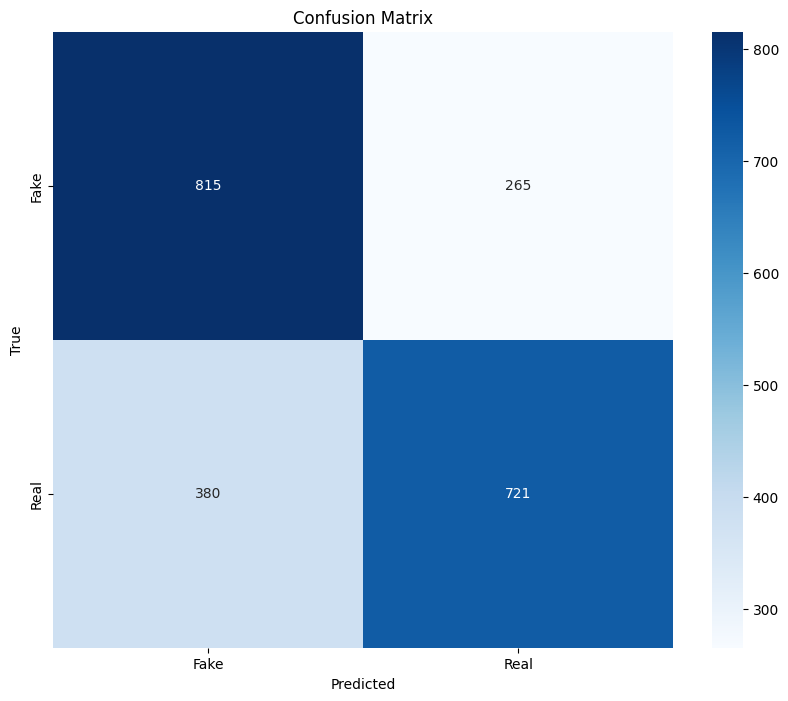

In [24]:
# evaluate the model
def evaluate_model(model, test_loader, classes, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # classification Report
    print(classification_report(all_labels, all_preds, target_names=classes))
    # confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# evaluate the model
evaluate_model(model, test_loader, test_data.classes, device)

In [ ]:
def plot_predictions(model, dataset, classes, device, n=10):
    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    axes = axes.flatten()
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
        # Plot the image
        img = img.squeeze().cpu().permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(
            f"True: {classes[label]}\nPred: {classes[pred]}", fontsize=10)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


# Plot predictions
plot_predictions(model, test_data, test_data.classes, device, n=10)

## Hyperparametr tunning

In [39]:
from itertools import product
# Define hyperparameter space
# param_space = {
#     "learning_rate": [0.01, 0.001, 0.0001],
#     "batch_size": [16, 32, 64],
#     "optimizer": ["SGD", "Adam", "RMSprop"],
#     "dropout_rate": [0.3, 0.5, 0.7]
# }

# using below arguments due to limitations of hardware if strong GPU availablle then use above arguments
param_space = {
    "learning_rate": [0.01, 0.0001],
    "batch_size": [32, 64],
    "optimizer": ["Adam", "SGD"],
    "dropout_rate": [0.5]
}


hyperparameter_combinations = list(product(
    param_space["learning_rate"],
    param_space["batch_size"],
    param_space["optimizer"],
    param_space["dropout_rate"]
))
print(f"Total combinations to test: {len(hyperparameter_combinations)}")

Total combinations to test: 8


In [41]:
# Define the model architecture
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [42]:
def train_and_evaluate(params):
    learning_rate, batch_size, optimizer_type, dropout_rate = params

    # update loaders with new batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # initialize model
    model = CustomCNN(dropout_rate=dropout_rate).to(device)

    # select optimizer
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # elif optimizer_type == "RMSprop":
    #     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # define scheduler and criterion
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    # train model
    model, train_loss, val_loss = train_custom_model(
        model, criterion, optimizer, scheduler, num_epochs=10
    )

    # evaluate model on validation set
    val_acc = 0
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
        val_acc = correct.double() / total

    return val_acc.item()

In [43]:
results = []

for params in hyperparameter_combinations:
    print(f"Testing combination: {params}")
    val_acc = train_and_evaluate(params)
    results.append((params, val_acc))
    print(f"Validation Accuracy: {val_acc:.4f}")

# find the best hyperparameters
best_params, best_val_acc = max(results, key=lambda x: x[1])
print(f"Best Hyperparameters: {best_params}, Best Validation Accuracy: {best_val_acc:.4f}")

Testing combination: (0.01, 32, 'Adam', 0.5)
Epoch 1/10
------------------------------
train Loss: 1.9448 Acc: 0.4976
val Loss: 0.6934 Acc: 0.4965
Epoch 2/10
------------------------------
train Loss: 0.6937 Acc: 0.4973
val Loss: 0.6940 Acc: 0.4965
Epoch 3/10
------------------------------
train Loss: 0.6936 Acc: 0.5014
val Loss: 0.6931 Acc: 0.5035
Epoch 4/10
------------------------------
train Loss: 0.6936 Acc: 0.4957
val Loss: 0.6933 Acc: 0.4965
Epoch 5/10
------------------------------
train Loss: 0.6936 Acc: 0.5014
val Loss: 0.6933 Acc: 0.4965
Epoch 6/10
------------------------------
train Loss: 0.6936 Acc: 0.4972
val Loss: 0.6934 Acc: 0.5035
Epoch 7/10
------------------------------
train Loss: 0.6936 Acc: 0.5000
val Loss: 0.6931 Acc: 0.5035
Epoch 8/10
------------------------------
train Loss: 0.6932 Acc: 0.4976
val Loss: 0.6931 Acc: 0.5035
Epoch 9/10
------------------------------
train Loss: 0.6932 Acc: 0.5025
val Loss: 0.6931 Acc: 0.5035
Epoch 10/10
-------------------------

Best Hyperparameters: (0.01, 64, 'SGD', 0.5), Best Validation Accuracy: 0.8732


In [45]:
best_model = CustomCNN(dropout_rate=best_params[3]).to(device)

# reinitialize optimizer and scheduler
if best_params[2] == "SGD":
    best_optimizer = optim.SGD(
        best_model.parameters(), lr=best_params[0], momentum=0.9)
elif best_params[2] == "Adam":
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params[0])
best_scheduler = optim.lr_scheduler.StepLR(
    best_optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# train the best model
best_model, _, _ = train_custom_model(
    best_model, criterion, best_optimizer, best_scheduler, num_epochs=15
)

# evaluate on test set
custom_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

print(f"Test Accuracy with Best Hyperparameters: {correct.double() / total:.4f}")

Epoch 1/15
------------------------------
train Loss: 0.5156 Acc: 0.7368
val Loss: 0.4675 Acc: 0.7672
Epoch 2/15
------------------------------
train Loss: 0.3732 Acc: 0.8316
val Loss: 0.4240 Acc: 0.7896
Epoch 3/15
------------------------------
train Loss: 0.3040 Acc: 0.8653
val Loss: 0.3652 Acc: 0.8282
Epoch 4/15
------------------------------
train Loss: 0.2516 Acc: 0.8927
val Loss: 0.3443 Acc: 0.8426
Epoch 5/15
------------------------------
train Loss: 0.2122 Acc: 0.9094
val Loss: 0.3723 Acc: 0.8375
Epoch 6/15
------------------------------
train Loss: 0.1764 Acc: 0.9277
val Loss: 0.3222 Acc: 0.8571
Epoch 7/15
------------------------------
train Loss: 0.1489 Acc: 0.9388
val Loss: 0.3480 Acc: 0.8562
Epoch 8/15
------------------------------
train Loss: 0.1047 Acc: 0.9604
val Loss: 0.3391 Acc: 0.8647
Epoch 9/15
------------------------------
train Loss: 0.0845 Acc: 0.9673
val Loss: 0.3635 Acc: 0.8656
Epoch 10/15
------------------------------
train Loss: 0.0752 Acc: 0.9709
val Loss

- Test Accuracy with Best Hyperparameters: 0.7969


In [46]:
# Save the best model
torch.save(best_model.state_dict(), "best_model.pth")
print("Best model saved as 'best_model.pth'.")

Best model saved as 'best_model.pth'.


In [47]:
# Load the model
loaded_model = CustomCNN(dropout_rate=best_params[3]).to(device)
loaded_model.load_state_dict(torch.load("/content/best_model.pth"))
loaded_model.eval()
print("Best model loaded successfully.")

Best model loaded successfully.


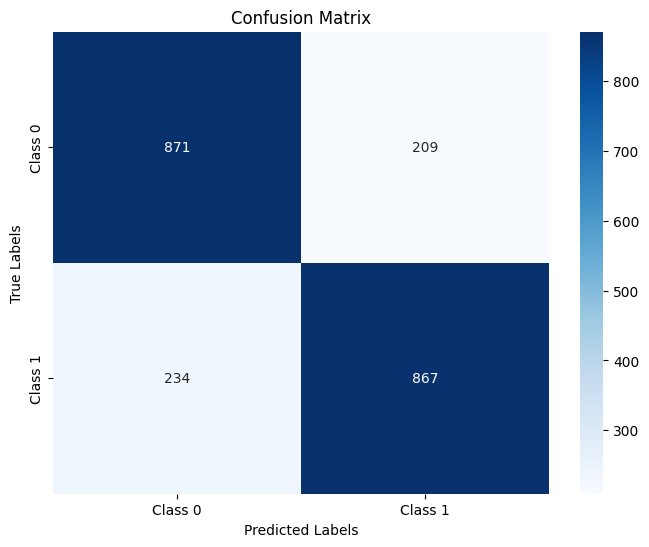

In [50]:
# # Define class names (e.g., if binary classification: ['Class 0', 'Class 1'])
class_names = ["Class 0", "Class 1"]

# Plot confusion matrix for the best model on test set
# plot_confusion_matrix(best_model, test_loader, class_names)


def plot_confusion_matrix(model, data_loader, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds,
                          labels=range(len(class_names)))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(best_model, test_loader, class_names)

In [52]:
def plot_predictions(model, data_loader, class_names, num_images=8):
    model.eval()
    inputs, labels = next(iter(data_loader))  # Get a batch of data
    inputs, labels = inputs[:num_images].to(
        device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    # Plot the images with predictions
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = inputs[i].cpu().permute(1, 2, 0).numpy()  # Convert to HWC format
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

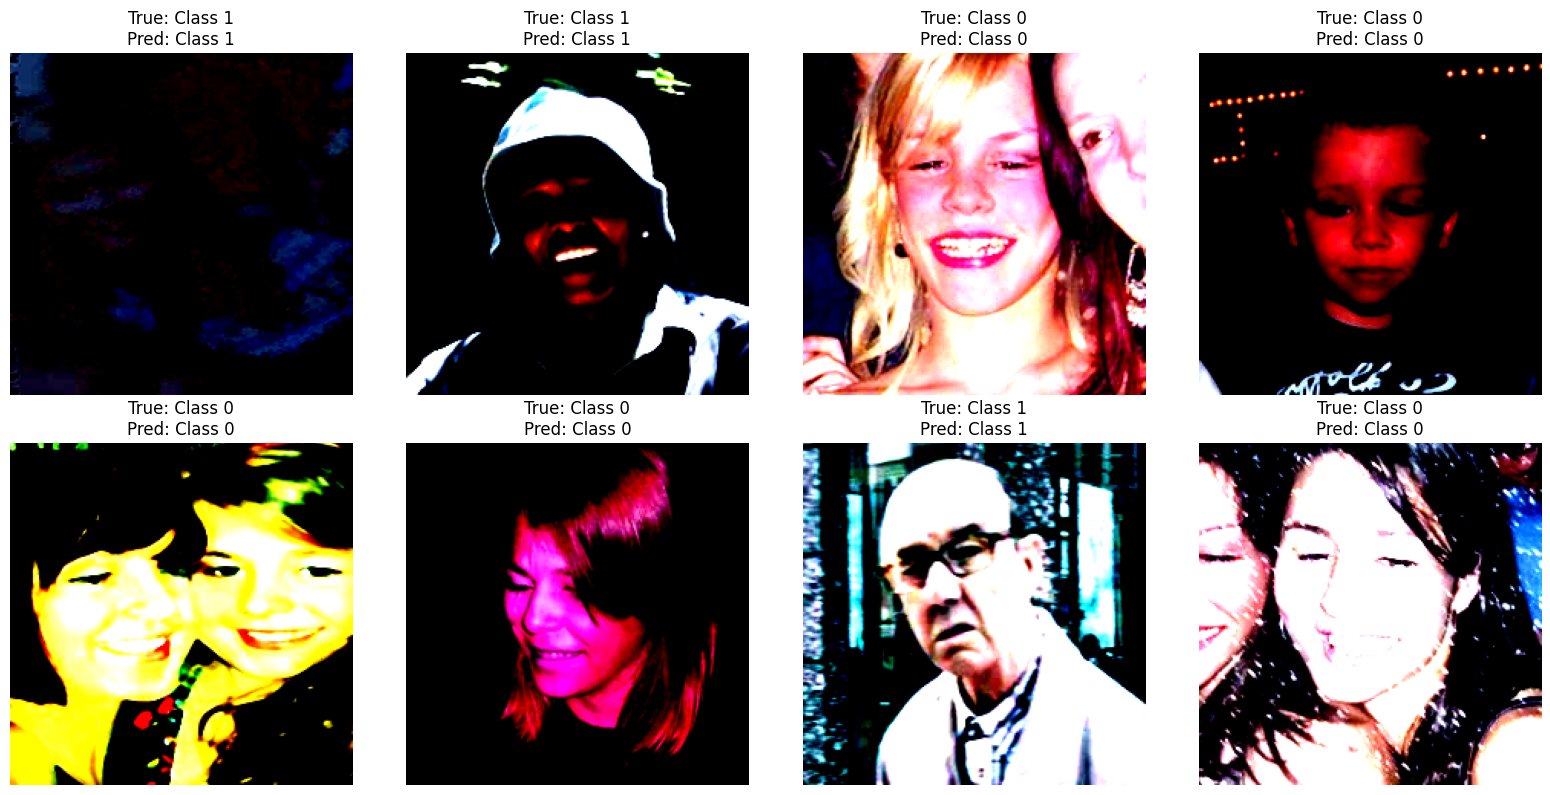

In [53]:
# Visualize predictions for the best model
plot_predictions(best_model, test_loader, class_names)